# 02. Домашнее задание. Обучение Vision Transformer


В этом задании вам предлагается дописать реализацию ViT и обучить его на датасете CIFAR-10. Хотя эта модель гораздо больше тех CNN, что мы изучали (и будем изучать), ресурсов colab-а гарантированно хватит, чтобы закончить обучение. Так же рекомендуется просмотреть Lab_5, Lab_3 и Lab_6 , поскольку это задание во многом основано на них.

**Ищите комментарии "Write your code here" для быстрого обнаружения мест, где вы должны что-то дописать!**

![](https://hashtelegraph.com/wp-content/uploads/2024/08/shooting-sparrows-with-a-cannon--1024x576.jpg)

## 1. Patch Embeddings

Отличительной особенностью ViT является эмбеддинги изображений. Чтобы представить изображение в виде входного вектора для трансформера, оно разбивается на фрагменты (patches) заданного размера. В нашей имплементации это будет сделано с помощью обучаемой свертки.

In [1]:
import torch
import torch.nn as nn

class PatchEmbeddings(nn.Module):
    """
    Преобразуйте изображение в патчи, а затем спроецируйте их в векторное пространство.
    """
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Количество фрагментов (патчей), исходя из размера изображения и размера фрагмента
        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Свертка, разбивающая изображение на патчи и проецирующая их в скрытое пространство
        self.projection = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        batch_size = x.shape[0]
        x = self.projection(x)  # -> (batch_size, hidden_size, num_patches_h, num_patches_w)
        x = x.flatten(2).transpose(1, 2)  # -> (batch_size, num_patches, hidden_size)
        assert x.shape[0] == batch_size
        assert x.shape[1] == self.num_patches
        assert x.shape[2] == self.hidden_size
        return x


In [2]:
import torch
import torch.nn as nn

class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        
        # Обучаемый токен [CLS]
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        
        # Позиционные эмбеддинги: +1 для [CLS]-токена
        self.position_embeddings = nn.Parameter(torch.randn(
            1, self.patch_embeddings.num_patches + 1, config["hidden_size"]
        ))
        
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        # Получаем патч-эмбеддинги: (batch_size, num_patches, hidden_size)
        x = self.patch_embeddings(x)
        
        batch_size = x.size(0)

        # Расширяем [CLS] токен для всего батча
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, hidden_size)
        
        # Добавляем [CLS] токен к началу последовательности
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, hidden_size)

        # Добавляем позиционные эмбеддинги
        x = x + self.position_embeddings

        # Dropout (регуляризация)
        x = self.dropout(x)
        
        return x


## 2. Attention head

Допишите реализацию головы трансформера. Формулы подсчеты attention score можно найти в Лекции 5, посвященной трансформерам

In [3]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax


class AttentionHead(nn.Module):
    """
    Голова трансформера — вычисляет внимание для одной "головы".
    """
    def __init__(self, hidden_size, attention_head_size, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        self.query = nn.Linear(hidden_size, attention_head_size)
        self.key = nn.Linear(hidden_size, attention_head_size)
        self.value = nn.Linear(hidden_size, attention_head_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_size)
        Q = self.query(x)  # (batch_size, seq_len, head_size)
        K = self.key(x)
        V = self.value(x)

        # Attention scores: (batch_size, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.attention_head_size ** 0.5)
        attention_weights = softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Weighted sum of values
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, seq_len, head_size)
        return attention_output


class MultiHeadAttention(nn.Module):
    """
    Модуль multi-head attention
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        assert self.hidden_size % self.num_attention_heads == 0, "hidden_size должен делиться на num_attention_heads"

        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Создаем головы внимания
        self.heads = nn.ModuleList([
            AttentionHead(self.hidden_size, self.attention_head_size, config["attention_probs_dropout_prob"])
            for _ in range(self.num_attention_heads)
        ])

        # Финальная линейная проекция
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        # Считаем внимание в каждой голове
        attention_outputs = [head(x) for head in self.heads]  # Список из тензоров (batch, seq_len, head_size)
        
        # Конкатенируем результаты по размерности скрытого пространства
        attention_output = torch.cat(attention_outputs, dim=-1)  # (batch, seq_len, all_head_size)

        # Финальное линейное преобразование
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        return attention_output


In [4]:

class MLP(nn.Module):
    """
    Многослойный персептрон
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


## 3. Encoder

Схема энкодера трансформера, используемого в ViT

![](https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png)


In [5]:
class Block(nn.Module):
    """
    Блок энкодера, как на рисунке сверху.
    Схема: x -> LN -> Attention -> Add -> LN -> MLP -> Add
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x):
        # Первый путь: LayerNorm -> Attention -> Residual
        residual = x
        x = self.layernorm_1(x)
        x = self.attention(x)
        x = x + residual  # Skip connection

        # Второй путь: LayerNorm -> MLP -> Residual
        residual = x
        x = self.layernorm_2(x)
        x = self.mlp(x)
        x = x + residual  # Skip connection

        return x



class Encoder(nn.Module):
    """
    Энкодер, состоящий из config["num_blocks"] блоков.
    """

    def __init__(self, config):
        super().__init__()
        # Создаём config["num_blocks"] энкодерных блоков
        self.blocks = nn.ModuleList([
            Block(config) for _ in range(config["num_blocks"])
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


In [ ]:
class ViTForClassfication(nn.Module):
    """
    Vision transformer. Состоит из PatchEmbedder-а, энкодера и линейного слоя
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
 
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]

        self.num_classes = config["num_classes"]

        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        embedding_output = self.embedding(x)
        encoder_output = self.encoder(embedding_output)
        # Рассчываем логиты как выходные данные токена [CLS]
        logits = self.classifier(encoder_output[:, 0, :])

        return logits

## 4. Подготовка датасета

Эта часть мало чем отличается от Lab_3, поэтому можете свериться с ней

In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms



def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # Трансформации для обучающего датасета
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),  # случайный кроп с масштабированием
        transforms.RandomHorizontalFlip(),  # случайное горизонтальное отражение
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)

    if train_sample_size is not None:
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    # Трансформации для тестового датасета
    test_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=test_transform)

    if test_sample_size is not None:
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    return trainloader, testloader


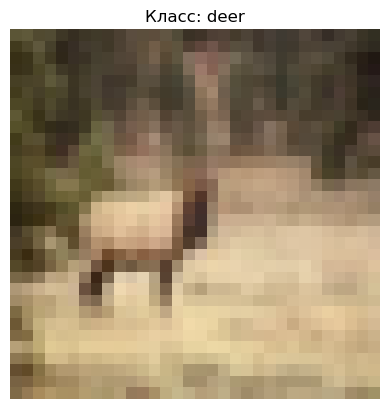

In [ ]:
import random
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

transform = transforms.ToTensor()

# Загружаем тестовый датасет (или можно train=True)
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#  случайный индекс
index = random.randint(0, len(dataset) - 1)
image, label = dataset[index]

# классы
classes = dataset.classes

plt.imshow(image.permute(1, 2, 0)) 
plt.title(f"Класс: {classes[label]}")
plt.axis("off")
plt.show()


# Finally, обучение!

Epoch [1/10] | Train Loss: 1.9839 | Train Acc: 0.2509 | Test Loss: 1.7468 | Test Acc: 0.3503


Epoch [2/10] | Train Loss: 1.8233 | Train Acc: 0.3211 | Test Loss: 1.6821 | Test Acc: 0.3684


Epoch [3/10] | Train Loss: 1.7530 | Train Acc: 0.3527 | Test Loss: 1.7279 | Test Acc: 0.3830


Epoch [4/10] | Train Loss: 1.6973 | Train Acc: 0.3768 | Test Loss: 1.5188 | Test Acc: 0.4436


Epoch [5/10] | Train Loss: 1.6384 | Train Acc: 0.4015 | Test Loss: 1.4655 | Test Acc: 0.4658


Epoch [6/10] | Train Loss: 1.5852 | Train Acc: 0.4211 | Test Loss: 1.4776 | Test Acc: 0.4671


Epoch [7/10] | Train Loss: 1.5285 | Train Acc: 0.4457 | Test Loss: 1.3644 | Test Acc: 0.4981


Epoch [8/10] | Train Loss: 1.4687 | Train Acc: 0.4708 | Test Loss: 1.3052 | Test Acc: 0.5306


Epoch [9/10] | Train Loss: 1.4141 | Train Acc: 0.4924 | Test Loss: 1.2582 | Test Acc: 0.5491


Epoch [10/10] | Train Loss: 1.3836 | Train Acc: 0.5047 | Test Loss: 1.2482 | Test Acc: 0.5526
Best Test Accuracy: 0.5526


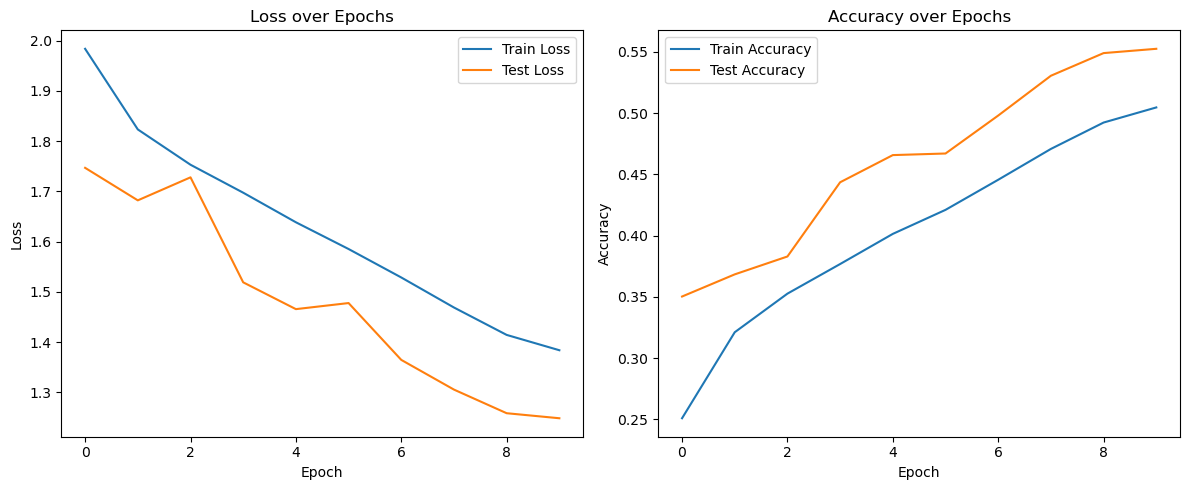

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

class Trainer:
    def __init__(self, model, optimizer, scheduler, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device


    def train(self, trainloader, testloader, epochs):
        best_accuracy = 0
        best_model_state = None

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0

            loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * images.size(0)

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += images.size(0)

                loop.set_postfix(loss=loss.item(), acc=correct / total)

            train_loss = total_loss / len(trainloader.dataset)
            train_acc = correct / total
            self.scheduler.step()

            test_acc, test_loss = self.evaluate(testloader)
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_model_state = copy.deepcopy(self.model.state_dict())

        print(f"Best Test Accuracy: {best_accuracy:.4f}")
        if best_model_state:
            self.model.load_state_dict(best_model_state)

        self.plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)




    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0

        for images, labels in testloader:
            images, labels = images.to(self.device), labels.to(self.device)
            logits = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)
        return accuracy, avg_loss

    def plot_metrics(self, train_losses, train_accuracies, test_losses, test_accuracies):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(test_accuracies, label="Test Accuracy")
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()



def main():
    batch_size = 32
    epochs = 10
    lr = 1e-2

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    config = {
        "patch_size": 4,
        "hidden_size": 48,
        "num_blocks": 4,
        "num_attention_heads": 4,
        "intermediate_size": 4 * 48,
        "hidden_dropout_prob": 0.1,
        "attention_probs_dropout_prob": 0.1,
        "initializer_range": 0.02,
        "image_size": 32,
        "num_classes": 10,
        "num_channels": 3,
    }

    trainloader, testloader = prepare_data(batch_size=batch_size)
    model = ViTForClassfication(config)
    model.apply(initialize_weights)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    trainer = Trainer(model, optimizer, scheduler, loss_fn, device)
    trainer.train(trainloader, testloader, epochs)


if __name__ == '__main__':
    main()
